<a href="https://colab.research.google.com/github/JahedNaghipoor/Classification-of-genes/blob/Test/DNA_Sequencing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DNA Sequencing 
predicting a gene's function based on the DNA sequence of the coding sequence alone

In [401]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [402]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

import os

In [403]:
directory = "/content/gdrive/MyDrive/Machine Learning and Deep Learning/Gene Classification/"

In [404]:
human_data = pd.read_table(os.path.join(directory, 'human_data.txt'))
human_data.head(10)

,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3
5,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
6,ATGAAGATTGCACACAGAGGTCCAGATGCATTCCGTTTTGAGAATG...,3
7,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3
8,ATGAAGATTGCACACAGAGGTCCAGATGCATTCCGTTTTGAGAATG...,3
9,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3


In [405]:
human_data['length of sequence'] = human_data.sequence.apply(len)

In [406]:
human_data.head()

,sequence,class,length of sequence
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4,207
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4,681
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3,1686
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3,1206
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3,1437


In [407]:
human_data.isnull().sum()

sequence              0
class                 0
length of sequence    0
dtype: int64

In [408]:
human_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4380 entries, 0 to 4379
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   sequence            4380 non-null   object
 1   class               4380 non-null   int64 
 2   length of sequence  4380 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 102.8+ KB


In [409]:
human_data.describe()

,class,length of sequence
count,4380.000000,4380.000000
mean,3.504566,1263.598630
std,2.132134,1280.754087
min,0.000000,5.000000
25%,2.000000,405.000000
50%,4.000000,865.000000
75%,6.000000,1662.000000
max,6.000000,18921.000000


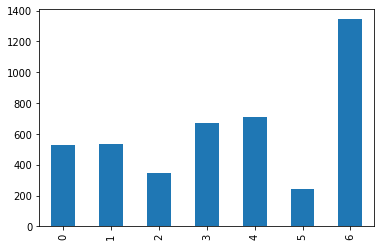

In [410]:
human_data['class'].value_counts().sort_index().plot(kind='bar')

In [411]:
'''from sklearn.utils import resample
# Separate class 6 and other classes
df_without_class6 = human_data[human_data['class']!=6]
df_with_class6 = human_data[human_data['class']==6]
 
# Upsample minority class
df_with_class6 = resample(df_with_class6, 
                                 replace=True,     
                                 n_samples=700,    
                                 random_state=123)
human_data = pd.concat([df_with_class6, df_without_class6])
human_data['class'].value_counts().sort_index().plot(kind='bar')'''

### Treating DNA sequence as a "language", otherwise known as  k-mer counting

A challenge that remains is that none of these above methods results in vectors of uniform length, and that is a requirement for feeding data to a classification or regression algorithm. So with the above methods you have to resort to things like truncating sequences or padding with "n" or "0" to get vectors of uniform length.

DNA and protein sequences can be viewed metaphorically as the language of life. The language encodes instructions as well as function for the molecules that are found in all life forms. The sequence language analogy continues with the genome as the book, subsequences (genes and gene families) are sentences and chapters, k-mers and peptides (motifs) are words, and nucleotide bases and amino acids are the alphabet. Since the analogy seems so apt, it stands to reason that the amazing work done in the natural language processing field should also apply to the natural language of DNA and protein sequences.

The method I use here is simple and easy. I first take the long biological sequence and break it down into k-mer length overlapping “words”. For example, if I use "words" of length 6 (hexamers), “ATGCATGCA” becomes: ‘ATGCAT’, ‘TGCATG’, ‘GCATGC’, ‘CATGCA’. Hence our example sequence is broken down into 4 hexamer words.

Here I am using hexamer “words” but that is arbitrary and word length can be tuned to suit the particular situation. The word length and amount of overlap need to be determined empirically for any given application.

In genomics, we refer to these types of manipulations as "k-mer counting", or counting the occurances of each possible k-mer sequence. There are specialized tools for this, but the Python natural language processing tools make it supe easy.

Here is a function that can be used to convert any sequence (string) to overlapping k-mer words:

### Let's define a function to collect all possible overlapping k-mers of a specified length from any sequence string. We will basically apply the k-mers to the complete sequences.

In [413]:
def getKmers(sequence, size):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

## Now we can convert our training data sequences into short overlapping  k-mers of legth 6.  Lets do that for each species of data we have using our getKmers function.

In [414]:
human_data['words'] = human_data.apply(lambda x: getKmers(sequence=x['sequence'], size=6), axis=1)
human_data = human_data.drop('sequence', axis=1)

### Now, our coding sequence data is changed to lowercase, split up into all possible k-mer words of length 6 and ready for the next step.  Let's take a look.

In [415]:
human_data.head()

,class,length of sequence,words
3609,6,1809,"[atgtcg, tgtcga, gtcgaa, tcgaat, cgaatg, gaatg..."
3260,6,1263,"[nctttt, cttttg, ttttgc, tttgca, ttgcag, tgcag..."
228,6,1476,"[atggtc, tggtct, ggtctg, gtctgt, tctgta, ctgta..."
3659,6,1314,"[atggcc, tggcct, ggcctt, gccttg, ccttgg, cttgg..."
4054,6,333,"[gccgtg, ccgtgc, cgtgca, gtgcag, tgcagc, gcagc..."


In [416]:
human_data['number of k-mer words'] = human_data.words.apply(len)

In [433]:
human_data.head(10)

,class,length of sequence,words,number of k-mer words
3609,6,1809,"[atgtcg, tgtcga, gtcgaa, tcgaat, cgaatg, gaatg...",1804
3260,6,1263,"[nctttt, cttttg, ttttgc, tttgca, ttgcag, tgcag...",1258
228,6,1476,"[atggtc, tggtct, ggtctg, gtctgt, tctgta, ctgta...",1471
3659,6,1314,"[atggcc, tggcct, ggcctt, gccttg, ccttgg, cttgg...",1309
4054,6,333,"[gccgtg, ccgtgc, cgtgca, gtgcag, tgcagc, gcagc...",328
218,6,204,"[atgcgt, tgcgtg, gcgtgc, cgtgcc, gtgccg, tgccg...",199
244,6,1056,"[atgacc, tgaccg, gaccga, accgaa, ccgaaa, cgaaa...",1051
2097,6,810,"[atgtac, tgtaca, gtacaa, tacaaa, acaaag, caaag...",805
106,6,505,"[atgaat, tgaatg, gaatga, aatgat, atgatt, tgatt...",500
138,6,1326,"[atgaag, tgaagg, gaaggc, aaggcg, aggcgg, ggcgg...",1321


### Since we are going to use scikit-learn natural language processing tools to do the k-mer counting, we need to now convert the lists of k-mers for each gene into string sentences of words that the count vectorizer can use.  We can also make a y variable to hold the class labels.  Let's do that now.

In [418]:
human_texts = list(human_data['words'])
for item in range(len(human_texts)):
    human_texts[item] = ' '.join(human_texts[item])
y_data = human_data.iloc[:, 0].values                         

In [419]:
print(human_texts[2])

atggtc tggtct ggtctg gtctgt tctgta ctgtac tgtaca gtacaa tacaat acaata caatat aatatg atatgt tatgtc atgtca tgtcaa gtcaag tcaaga caagaa aagaag agaaga gaagag aagagt agagta gagtat agtatt gtattc tattca attcag ttcaga tcagaa cagaag agaagc gaagct aagctc agctcc gctccc ctccca tcccaa cccaat ccaatg caatga aatgaa atgaaa tgaaat gaaatg aaatgg aatggt atggtt tggtta ggttat gttata ttatat tatatg atatgt tatgtg atgtga tgtgac gtgaca tgacaa gacaag acaagt caagtg aagtgt agtgtg gtgtgg tgtggc gtggcc tggcca ggccaa gccaag ccaagg caagga aaggat aggata ggatat gatatc atatca tatcat atcatc tcatca catcag atcagt tcagtt cagttg agttgt gttgtg ttgtgt tgtgtc gtgtca tgtcac gtcaca tcacac cacaca acacac cacacc acacct cacctc acctca cctcat ctcata tcatat catatt atattg tattga attgat ttgatt tgattc gattcc attcca ttccag tccagt ccagtg cagtgt agtgtg gtgtga tgtgat gtgatt tgattg gattga attgat ttgatt tgattc gattca attcag ttcaga tcagat cagatg agatga gatgaa atgaaa tgaaaa gaaaaa aaaaat aaaatg aaatgg aatggc atggct tggctc ggctct gctctg ctctgt tctgtc

In [420]:
y_data

array([6, 6, 6, ..., 0, 0, 0])

## Now we will apply the BAG of WORDS using CountVectorizer using NLP

In [421]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(4,4))
X = cv.fit_transform(human_texts)

In [422]:
print(X.shape)

(3737, 229894)


In [423]:
# Splitting the human dataset into the training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y_data, 
                                                    test_size = 0.20, 
                                                    random_state=42)

In [424]:
print(X_train.shape)
print(X_test.shape)

(2989, 229894)
(748, 229894)


In [425]:
from sklearn.linear_model import LogisticRegression

In [426]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [427]:
y_pred = classifier.predict(X_test)

In [428]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

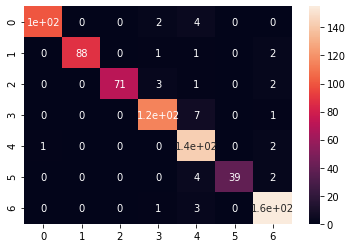

In [429]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True)

In [430]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.94      0.97       106
           1       1.00      0.96      0.98        92
           2       1.00      0.92      0.96        77
           3       0.94      0.93      0.94       123
           4       0.88      0.98      0.93       146
           5       1.00      0.87      0.93        45
           6       0.95      0.97      0.96       159

    accuracy                           0.95       748
   macro avg       0.97      0.94      0.95       748
weighted avg       0.95      0.95      0.95       748



In [431]:
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f \n precision = %.3f \n recall = %.3f \n f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.951 
 precision = 0.954 
 recall = 0.951 
 f1 = 0.951
